In [78]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot
from simulations.analysis.plotting_helpers import load_data

In [22]:
df_ps_dict = load_data(["surface", "surface_matching"], prefixes=["", "matching_"])

## pfail vs pabort

In [10]:
from plotting_helpers import take_best_by_from_df_ps_dict

df_ps_best = take_best_by_from_df_ps_dict(
    df_ps_dict,
    exclude=(lambda by: "matching" in by or by in {"pred_llr", "detector_density"}),
    use_pfail_upper=False,
)

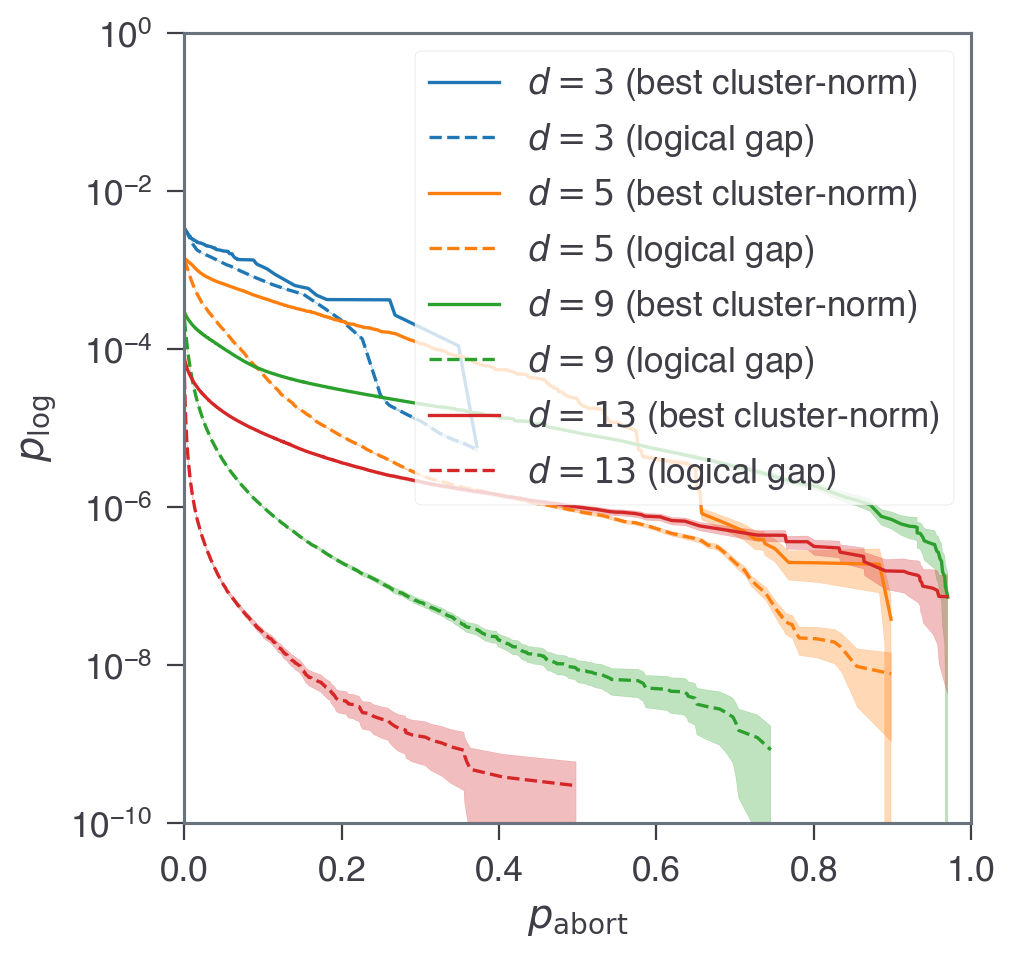

In [11]:
from plotting_helpers import get_lower_envelope

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

p = 0.005

dlist = df_ps_best.index.get_level_values("d").unique()
df_ps_matching_gap_all = df_ps_dict["matching_gap"]

for i_d, d in enumerate(dlist):
    df_ps_d = df_ps_best.loc[idx[d, d, p, :], :]
    p_abort = df_ps_d.index.get_level_values("p_abort").values
    p_fail = df_ps_d["p_fail"].values / d
    delta_p_fail = df_ps_d["delta_p_fail"].values / d
    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i_d),
        label=rf"$d={d}$ (best cluster-norm)",
        ax=ax,
    )

    try:
        df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
    except KeyError:
        continue
    df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
    p_abort = df_ps_matching_gap["p_abort"].values
    p_fail = df_ps_matching_gap["p_fail"].values / d
    delta_p_fail = df_ps_matching_gap["delta_p_fail"].values / d
    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i_d),
        label=rf"$d={d}$ (logical gap)",
        linestyle="--",
        ax=ax,
    )

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{log}$")

fig.tight_layout()

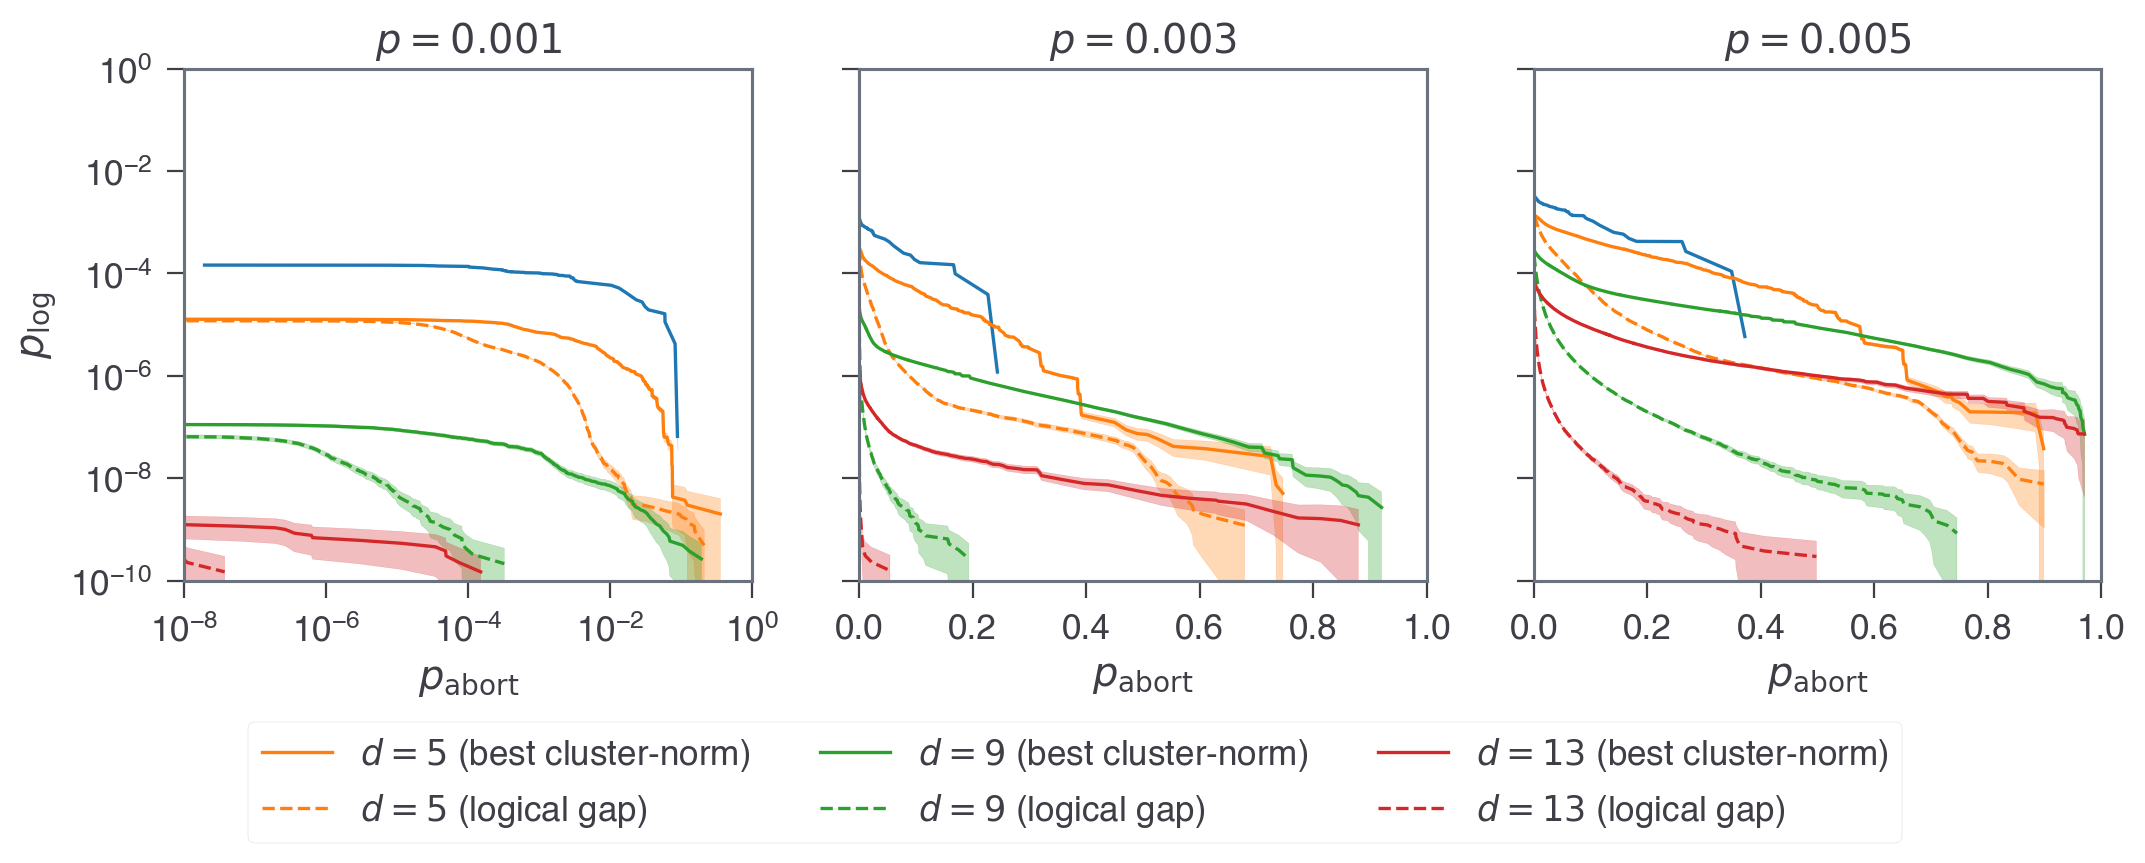

In [178]:
from plotting_helpers import get_lower_envelope, error_band_plot

fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4), sharey=True)

p_values = [0.001, 0.003, 0.005]

dlist = df_ps_best.index.get_level_values("d").unique()
df_ps_matching_gap_all = df_ps_dict["matching_gap"]

# Create legend handles and labels
legend_handles = []
legend_labels = []

for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps_best.loc[idx[d, d, p, :], :]
        p_abort = df_ps_d.index.get_level_values("p_abort").values
        p_fail = df_ps_d["p_fail"].values / d
        delta_p_fail = df_ps_d["delta_p_fail"].values / d
        line1 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_d),
            label=rf"$d={d}$ (best cluster-norm)",
            ax=ax,
        )

        try:
            df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
        except KeyError:
            continue
        df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
        p_abort = df_ps_matching_gap["p_abort"].values
        p_fail = df_ps_matching_gap["p_fail"].values / d
        delta_p_fail = df_ps_matching_gap["delta_p_fail"].values / d
        line2 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_d),
            label=rf"$d={d}$ (logical gap)",
            linestyle="--",
            ax=ax,
        )

        # Collect legend handles and labels only from the first subplot
        if i_p == 0:
            legend_handles.extend([line1[0], line2[0]])
            legend_labels.extend(
                [rf"$d={d}$ (best cluster-norm)", rf"$d={d}$ (logical gap)"]
            )

    if i_p == 0:
        ax.set_xscale("log")
        ax.set_xlim(1e-8, 1)
    else:
        ax.set_xlim(0, 1)
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1)
    ax.set_xlabel(r"$p_\mathrm{abort}$")
    ax.set_title(f"$p = {p}$")

    if i_p == 0:
        ax.set_ylabel(r"$p_\mathrm{log}$")

# Add legend below the figure with 3 columns
fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

fig.tight_layout()
plt.subplots_adjust(bottom=0.25)

logical error rate vs spacetime cost (code distance & abort rate) at a physical error rate
or vs footprint (space cost)

In [28]:
from plotting_helpers import load_ps_data

df_ps_dict = load_ps_data(["surface", "surface_matching"], prefixes=["", "matching_"])

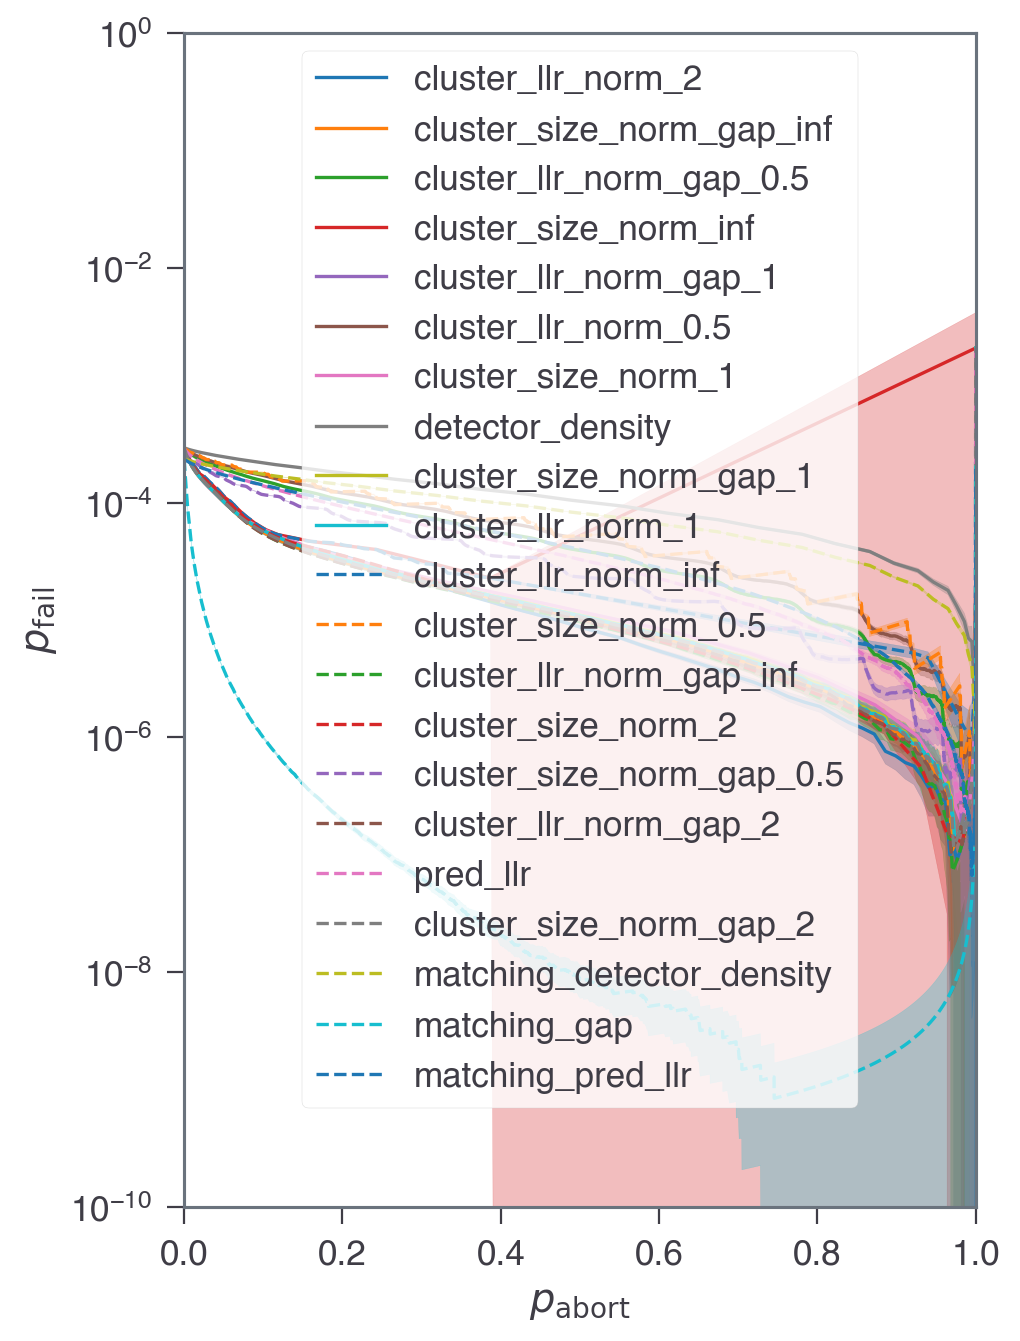

In [29]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 7))

d = T = 9
p = 0.005

i = 0
data_plots = {}
for by, df_ps_all in df_ps_dict.items():
    # if True:
    if True:
        p_abort_col = "p_abort"
        p_fail_col = "p_fail"
        delta_p_fail_col = "delta_p_fail"

        df_ps = df_ps_all.loc[idx[d, T, p, :], :]

        df_ps = df_ps.sort_values(by=p_abort_col)
        p_abort = df_ps[p_abort_col].values
        p_fail = df_ps[p_fail_col].values / T
        delta_p_fail = df_ps[delta_p_fail_col].values / T
        data_plots[by] = (p_abort, p_fail, delta_p_fail)

        error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i % 10),
            linestyle="-" if i < 10 else "--",
            label=by,
            ax=ax,
        )
        i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

relation to BP convergence

0: matching_gap (5.51e-03 ± 2.08e-05)
1: cluster_llr_norm_gap_1 (7.39e-03 ± 2.40e-05)
2: cluster_llr_norm_1 (7.39e-03 ± 2.40e-05)
3: cluster_llr_norm_gap_2 (7.44e-03 ± 2.41e-05)
4: cluster_llr_norm_gap_inf (7.46e-03 ± 2.41e-05)
5: cluster_llr_norm_2 (7.53e-03 ± 2.42e-05)
6: cluster_llr_norm_inf (7.55e-03 ± 2.42e-05)
7: pred_llr (7.59e-03 ± 2.43e-05)
8: matching_pred_llr (7.67e-03 ± 2.44e-05)
9: cluster_llr_norm_gap_0.5 (7.75e-03 ± 2.45e-05)
10: cluster_llr_norm_0.5 (7.83e-03 ± 2.47e-05)
11: detector_density (8.38e-03 ± 2.54e-05)


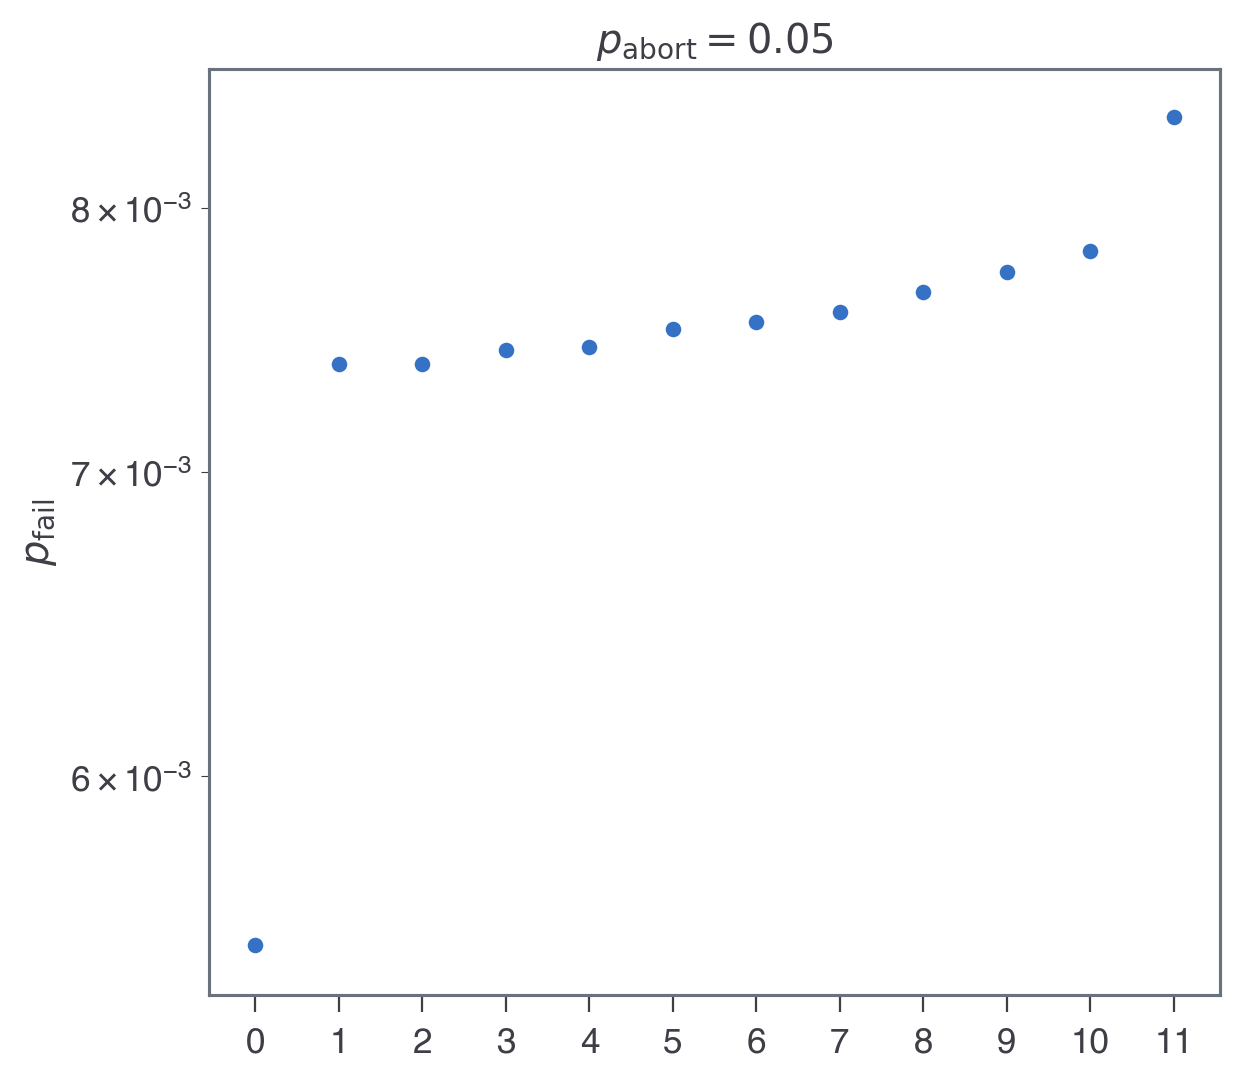

In [19]:
target = 0.05
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()

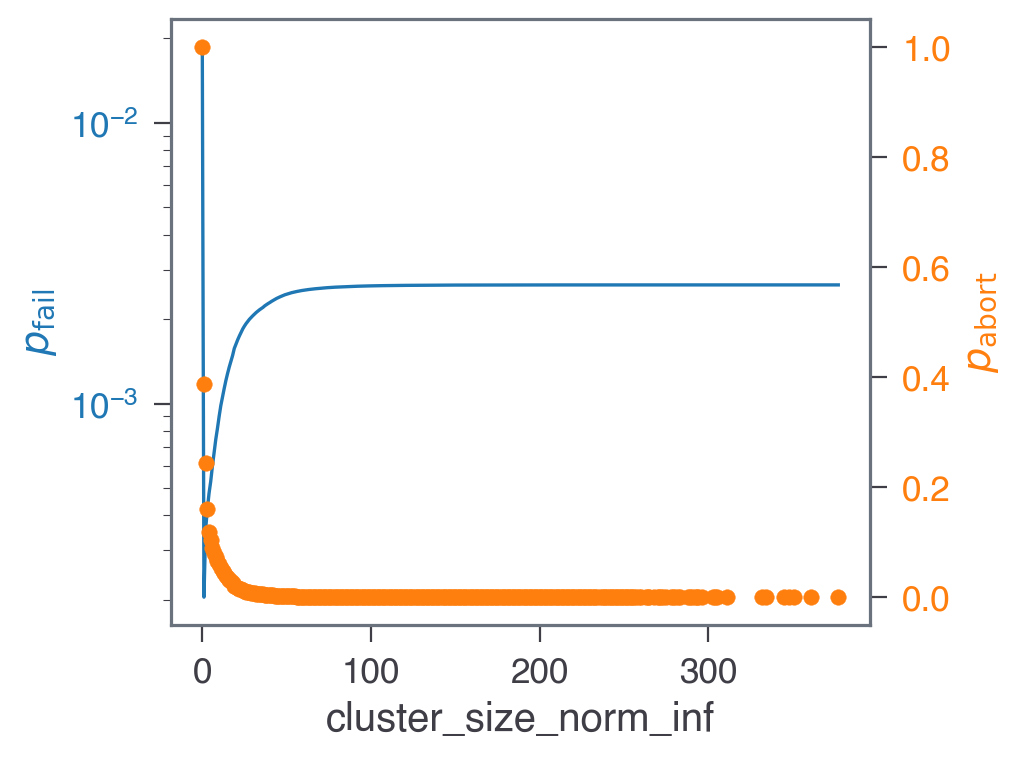

In [108]:
d = T = 9
p = 0.005
by = "cluster_size_norm_inf"

df_ps = df_ps_dict[by].loc[idx[d, T, p, :], :]

x_vals = df_ps.index.get_level_values(3).values
p_fail = df_ps["p_fail"].values
p_abort = df_ps["p_abort"].values

fig, ax1 = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

color1 = COLORS(0)
color2 = COLORS(1)

ax1.plot(x_vals, p_fail, color=color1, label="p_fail")
ax1.set_ylabel(r"$p_\mathrm{fail}$", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xlabel(by)
ax1.set_yscale("log")

ax2 = ax1.twinx()
ax2.scatter(x_vals, p_abort, color=color2, label="p_abort")
ax2.set_ylabel(r"$p_\mathrm{abort}$", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

fig.tight_layout()

0: matching_gap (1.35e-09 ± 7.64e-10)
1: cluster_llr_norm_gap_inf (1.86e-06 ± 2.97e-08)
2: cluster_llr_norm_gap_2 (1.88e-06 ± 2.98e-08)
3: cluster_llr_norm_1 (2.00e-06 ± 3.08e-08)
4: cluster_llr_norm_gap_1 (2.00e-06 ± 3.08e-08)
5: cluster_llr_norm_2 (2.08e-06 ± 3.14e-08)
6: cluster_llr_norm_inf (2.76e-06 ± 3.62e-08)
7: cluster_llr_norm_gap_0.5 (6.60e-06 ± 5.59e-08)
8: pred_llr (6.74e-06 ± 5.65e-08)
9: matching_pred_llr (7.21e-06 ± 5.85e-08)
10: cluster_llr_norm_0.5 (8.15e-06 ± 6.22e-08)
11: matching_detector_density (1.15e-05 ± 7.32e-08)
12: detector_density (1.58e-05 ± 8.57e-08)


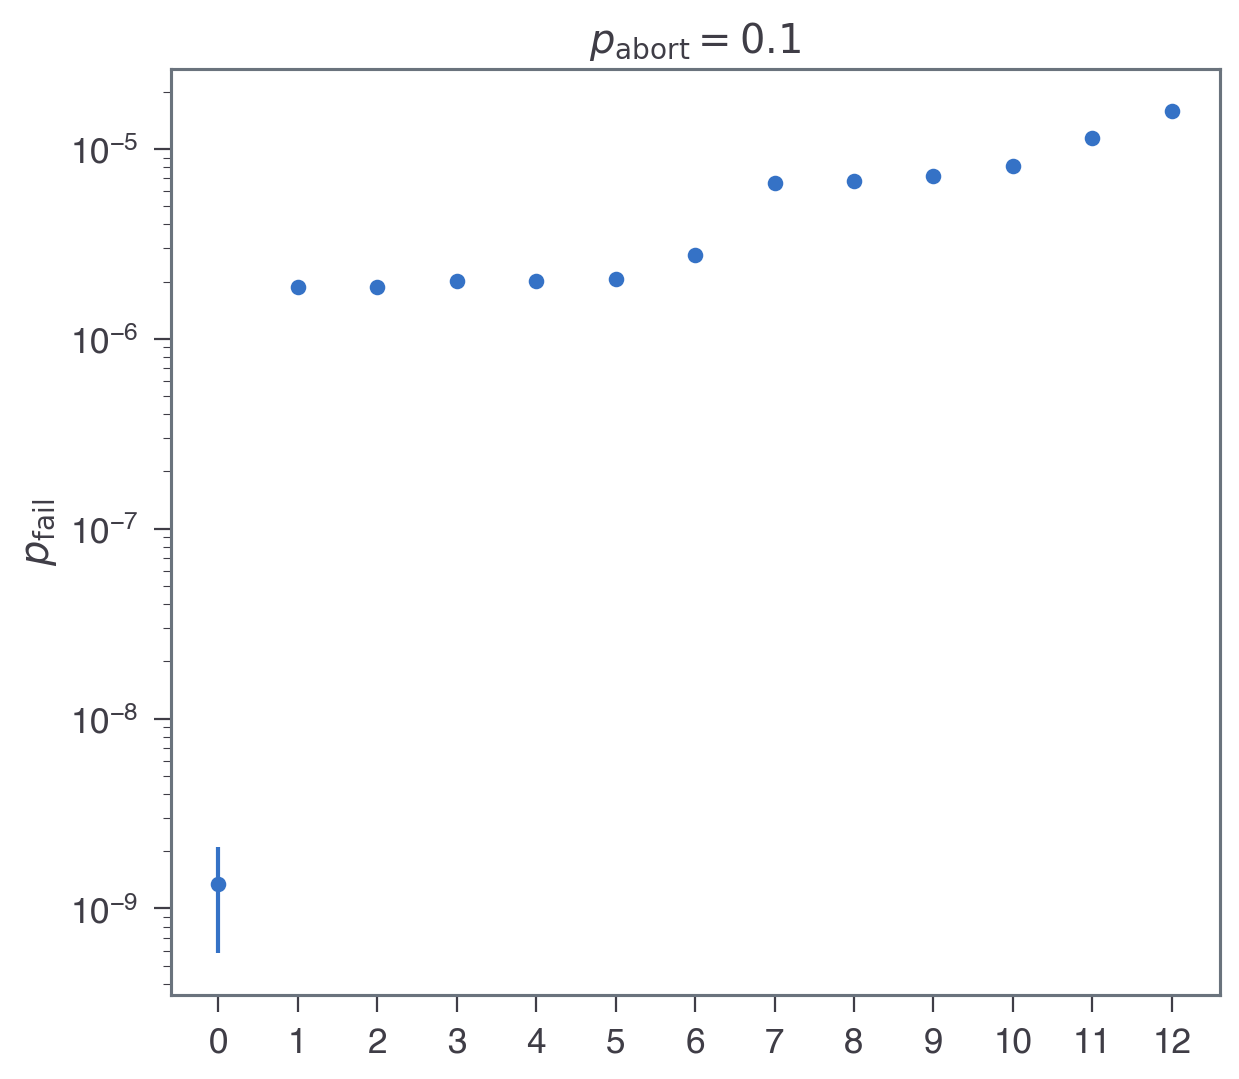

## pfail vs p for a fixed abort rate

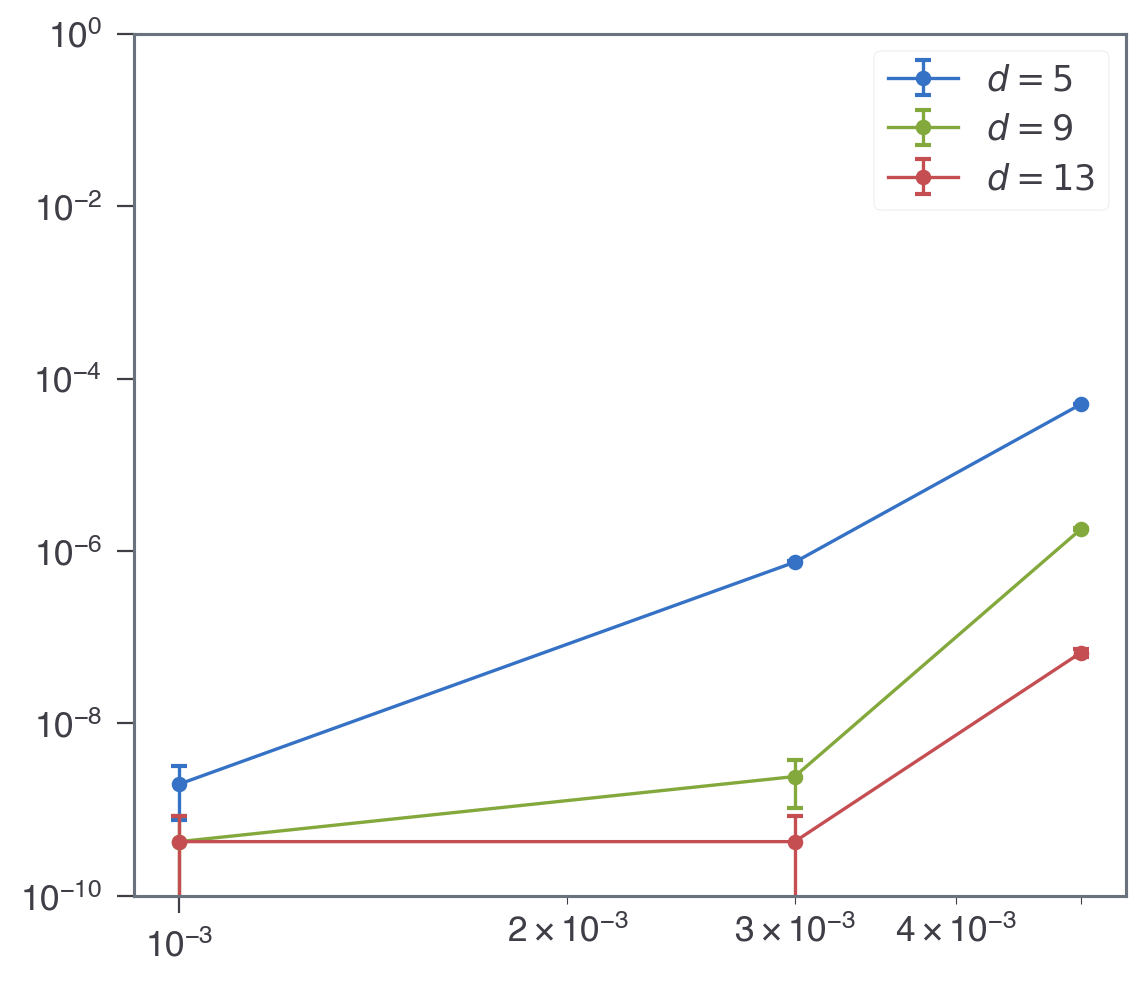

In [101]:
by = "matching_gap"
target_p_abort = 0.1

df_ps = df_ps_dict[by]
dlist = df_ps.index.get_level_values("d").unique()
for i_d, d in enumerate(dlist):
    df_ps_d = df_ps.loc[idx[d, d, :, :], :]
    plist = df_ps_d.index.get_level_values("p").unique()
    pfails = []
    delta_pfails = []
    for i_p, p in enumerate(plist):
        df_ps_dp = df_ps_d.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_dp["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_dp.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_dp.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        plist,
        pfails,
        yerr=delta_pfails,
        label=f"$d={d}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-10, 1)
plt.legend()

## pfail vs d for a fixed abort rate

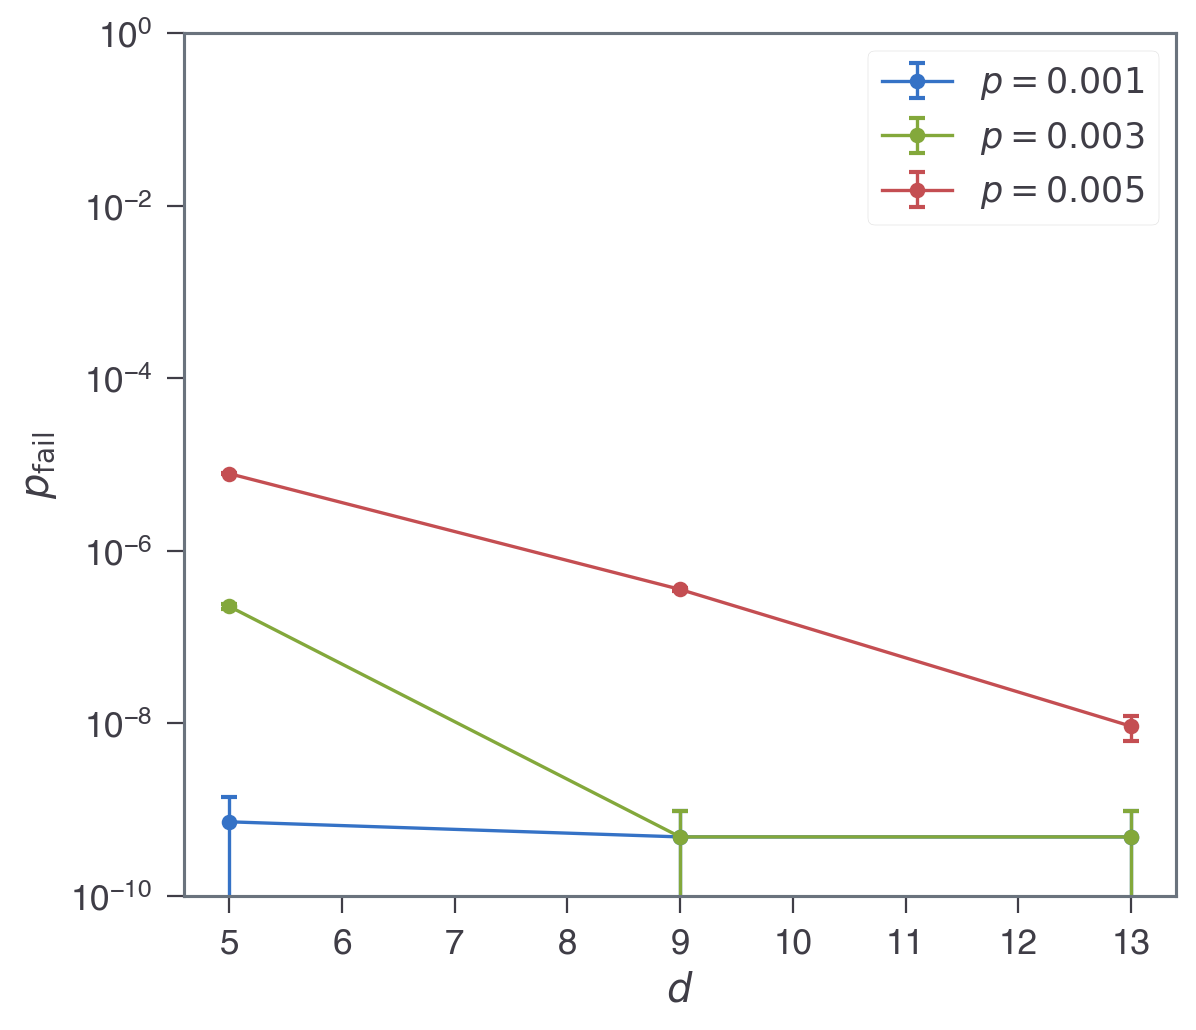

In [104]:
by = "matching_gap"
target_p_abort = 0.2

df_ps = df_ps_dict[by]
plist = df_ps.index.get_level_values("p").unique()
dlist = df_ps.index.get_level_values("d").unique()

for i_p, p in enumerate(plist):
    pfails = []
    delta_pfails = []
    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_d["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_d.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_d.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        dlist,
        pfails,
        yerr=delta_pfails,
        label=f"$p={p}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.ylim(1e-10, 1)
plt.xlabel("$d$")
plt.ylabel("$p_{\\mathrm{fail}}$")
plt.legend()

## Cluster norm distribution

In [74]:
df_agg_dict = load_data("surface", "agg")

In [109]:
by = "cluster_llr_norm_gap_2"
d = T = 9
p = 5e-3
df_agg = df_agg_dict[by].loc[(d, T, p)]
df_agg["num_succs"] = df_agg["count"] - df_agg["num_fails"]
df_agg.head()

,count,num_fails,num_converged,num_converged_fails,num_succs
cluster_llr_norm_gap,,,,,
6115.679688,1,1,0,0,0
6342.323730,1,0,0,0,1
6405.879883,1,0,0,0,1
6457.044434,1,0,0,0,1
6475.831543,1,0,0,0,1


Text(0.5, 0, 'cluster_llr_norm_gap_2')

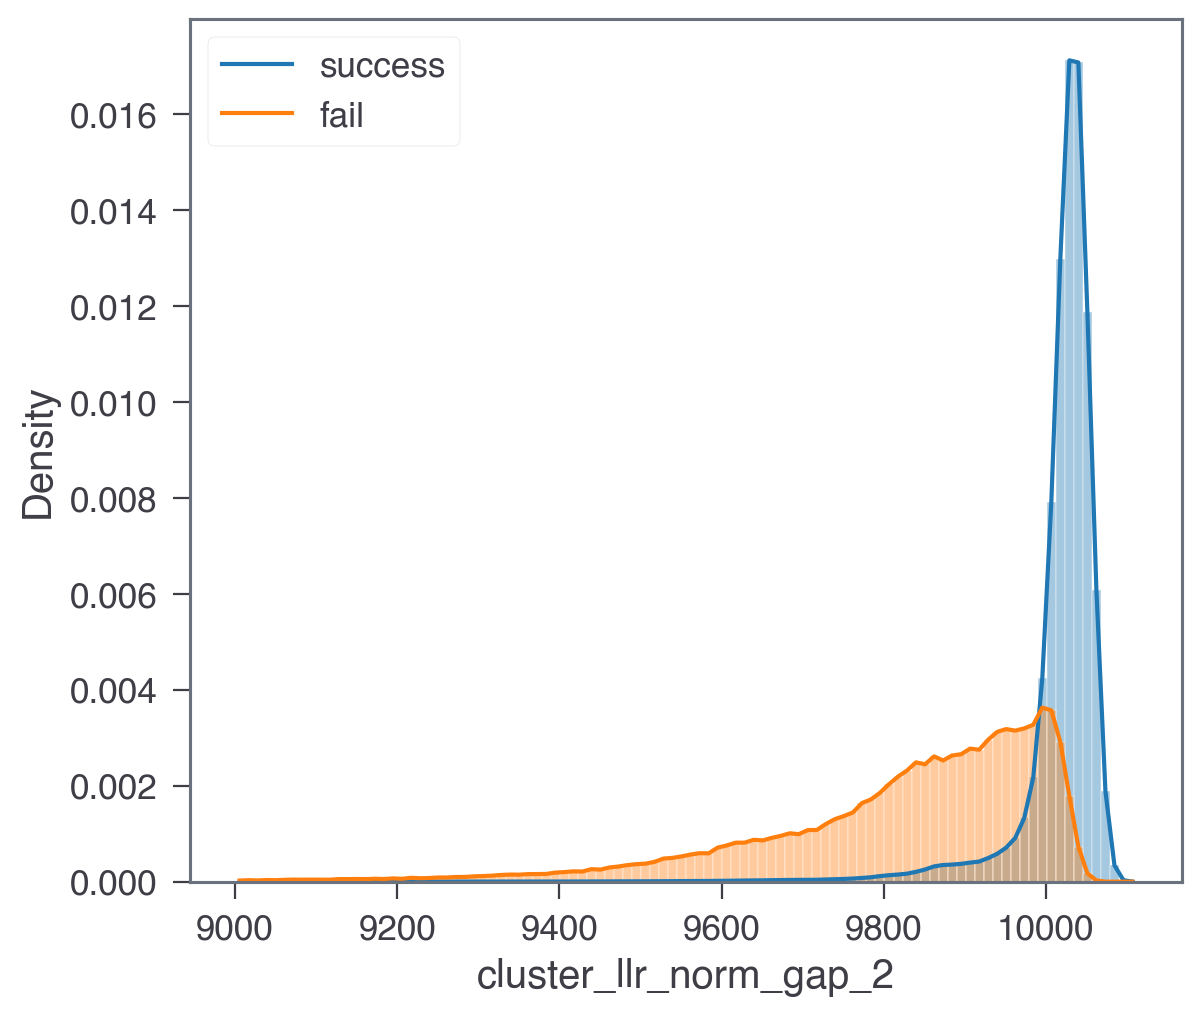

In [117]:
bin_range = (9000, df_agg.index.max())
bins = 100

sns.histplot(
    df_agg.reset_index(),
    x="cluster_llr_norm_gap",
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(0),
)

sns.histplot(
    df_agg.reset_index(),
    x="cluster_llr_norm_gap",
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="success",
    color=COLORS(0),
    element="poly",
    linewidth=1.5,
)

sns.histplot(
    df_agg.reset_index(),
    x="cluster_llr_norm_gap",
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(1),
)

sns.histplot(
    df_agg.reset_index(),
    x="cluster_llr_norm_gap",
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="fail",
    color=COLORS(1),
    element="poly",
    linewidth=1.5,
)
plt.legend()
plt.xlabel(by)